In [1]:
# Import necessary packages
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [2]:
# Initialize instance of H2O
h2o.init(strict_version_check = False)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 hour 8 mins
H2O cluster version:,3.11.0.99999
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_megankurka_2y0s6j
H2O cluster total nodes:,1
H2O cluster free memory:,1.320 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [3]:
#Set file path
path = "/Users/megankurka/Work/h2o-3/bigdata/laptop/lending-club"

In [4]:
#Parse with user imposed schema which changes the column types;
#Change the column types in the parse setup
#Change "int_rate," "revol_util," "emp_length," "verification_status" to String instead of Enum
col_types = {"int_rate": "string", "revol_util":"string", "emp_length":"string", "term":"string",
            "mths_since_last_delinq":"numeric", "mths_since_last_record":"numeric", 
             "mths_since_last_major_derog":"numeric"}

In [5]:
#Import data and set column types to those specified above
loan_stats = h2o.import_file(path = path, col_types = col_types)

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


In [6]:
# Look at the levels int he response column, "loan_status"
# Hint: Use .table() function on the response column
loan_stats["loan_status"].table()

loan_status,Count
Charged Off,29077
Current,374294
Default,178
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,131983
In Grace Period,3972
Late (16-30 days),1494


In [7]:
# Drop all loans that are still in progess and therefore cannot be deemed good/bad loans
# Hint: "Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)" are ongoing loans
loan_stats = loan_stats[~loan_stats["loan_status"].isin(["Current", "In Grace Period", "Late (16-30 days)", 
                                                         "Late (31-120 days)"]), :]

In [8]:
loan_stats["bad_loan"] = ~(loan_stats["loan_status"] == "Fully Paid")
loan_stats["bad_loan"] = loan_stats["bad_loan"].asfactor()

In [9]:
# Bin the response variable to good/bad oans only, use your best judgement for what qualifies as a good/bad loan
# Create a new column called "bad_loan" which should be a binary variable
# Hint: You can turn the bad_loan columm into a factor using .asfactor()


In [10]:
## String munging to clean string columns before converting to numeric
## Hint: Columns that need munging includes "int_rate", "revol_util", "emp_length", "term"

## Example for int_rate using h2o.strsplit, trim, as.numeric
loan_stats["int_rate"] = loan_stats["int_rate"].gsub(pattern = "%", replacement = "") # strip %
loan_stats[ "int_rate"] = loan_stats["int_rate"].trim() # trim ws
loan_stats["int_rate"] = loan_stats["int_rate"].asnumeric() #change to a numeric 
loan_stats["int_rate"].show()

int_rate
10.65
15.27
15.96
13.49
7.9
18.64
21.28
12.69
14.65
12.69


In [11]:
# Now try for revol_util yourself
loan_stats["revol_util"] = loan_stats["revol_util"].gsub(pattern = "%", replacement = "")
loan_stats["revol_util"] = loan_stats["revol_util"].trim() 
loan_stats["revol_util"] = loan_stats["revol_util"].asnumeric()
loan_stats["revol_util"] = loan_stats["revol_util"]/100
loan_stats["revol_util"].show()

revol_util
0.837
0.094
0.985
0.21
0.283
0.875
0.326
0.365
0.206
0.671


In [12]:
# Now we're going to clean up emp_length
# Use gsub to remove " year" and " years" also translate n/a to "" 
loan_stats ["emp_length"] = loan_stats["emp_length"].gsub(pattern = "([ ]*+[a-zA-Z].*)|(n/a)", 
                                              replacement = "")
# Use trim to remove any trailing spaces 
loan_stats ["emp_length"] = loan_stats["emp_length"].trim()

In [13]:
# Use sub to convert < 1 to 0 years and do the same for 10 + to 10
# Hint: Be mindful of spaces between characters
loan_stats ["emp_length"] = loan_stats["emp_length"].gsub(pattern = "< 1", replacement = "0")
loan_stats ["emp_length"] = loan_stats["emp_length"].gsub(pattern = "10\\+", replacement = "10")
loan_stats ["emp_length"] = loan_stats["emp_length"].asnumeric()
loan_stats ["emp_length"].show()

emp_length
10
0
10
10
3
9
4
0
5
10


In [14]:
# Convert the term column to a numeric from a string 
loan_stats["term"] = loan_stats["term"].gsub(pattern = " months", replacement = "")
loan_stats["term"] = loan_stats["term"].trim()
loan_stats["term"] = loan_stats["term"].asnumeric()

In [15]:
# Create a new column called "credit_length_in_years" by subtracting the values in "earliest_cr_line" from "issue_d"
# Hint: Convert earliest_cr_line and issue_d using .year() function before completing calculation
loan_stats["credit_length_in_years"] = loan_stats["issue_d"].year() - loan_stats["earliest_cr_line"].year()

In [16]:
# Use the sub function to create two levels from the verification_status column. 
#Ie "verified" and "not verified"
loan_stats["verification_status"] = (loan_stats["verification_status"] == "not verified").ifelse("not verified", 
                                                                                              "verified")
loan_stats["verification_status"].table()

verification_status,Count
verified,104841
not verified,59155


In [17]:
# Create a few new features using available ratios 

# Take the log of annual_inc
loan_stats["annual_inc_log"] = (loan_stats["annual_inc"] ==  0).ifelse(0, loan_stats["annual_inc"].log())

In [18]:
# Calculate the users' total available credit limit across all credit lines
loan_stats["avail_credit"] = (loan_stats["revol_util"] == 0).ifelse(float('nan'), loan_stats["revol_bal"]/loan_stats["revol_util"])
loan_stats["avail_credit_log"] = (loan_stats["avail_credit"] == 0).ifelse(0, loan_stats["avail_credit"].log())

Parse progress: |█████████████████████████████████████████████████████████████████████████████| 100%


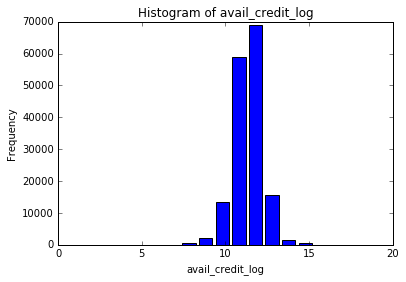

In [19]:
%matplotlib inline
loan_stats["avail_credit_log"].hist()

In [20]:
# Calculate the users' monthly debt vs monthly income and the increase in monthly debt with the new loan
loan_stats["monthly_debt"] = ((loan_stats["annual_inc"]/12)*(loan_stats["dti"]))
loan_stats["monthly_inc"] = loan_stats["annual_inc"]/12
loan_stats["new_monthly_debt"] = loan_stats["monthly_debt"] + loan_stats["installment"]

In [21]:
# Calculate the new debt to income ratio with the new debt, as well as the change in the dti ratio
loan_stats["dti2"] = loan_stats["new_monthly_debt"]/loan_stats["monthly_inc"]
loan_stats["dti_delta"] = loan_stats["dti2"] - loan_stats["dti"]

In [22]:
# Calculate ratio of available credit to income
loan_stats["avail_credit_util"] = loan_stats["avail_credit"]/loan_stats["annual_inc"]
loan_stats["avail_credit_util_log"] = (loan_stats["avail_credit_util"] == 0).ifelse(0,
                                                                        loan_stats["avail_credit_util"].log())

In [23]:
# Find out how many loans are bad in each year in the dataset
loan_stats = loan_stats[~(loan_stats["member_id"].isna()),:]
loan_stats["issue_d_year"] = loan_stats["issue_d"].year()

grouped = loan_stats.group_by(["issue_d_year"])
loans_by_year = grouped.count().sum("bad_loan").get_frame()
loans_by_year_df = loans_by_year.as_data_frame(use_pandas = True)

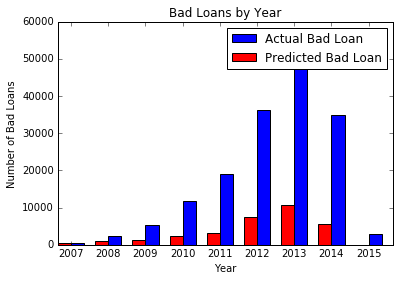

In [24]:
# Plot number of actual and predicted bad loans
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
width = 0.35 
rects1 = ax.bar(loans_by_year_df["issue_d_year"] + width, loans_by_year_df["nrow_id"], width, color='b')
rects2 = ax.bar(loans_by_year_df["issue_d_year"], loans_by_year_df["sum_bad_loan"], width, color='r')

ax.set_ylabel('Number of Bad Loans')
ax.set_xlabel('Year')

ax.set_title('Bad Loans by Year')
ax.set_xticks(loans_by_year_df["issue_d_year"] + width)
ax.set_xticklabels(loans_by_year_df["issue_d_year"])

ax.legend((rects1[0], rects2[0]), ('Actual Bad Loan', 'Predicted Bad Loan'))

In [25]:
# Do a test-train split (80-20)
s = loan_stats["int_rate"].runif()
train = loan_stats[s <= 0.80]
test  = loan_stats[s > 0.80]

In [24]:
# Define your response and predictor variables
myY = "bad_loan"
myX = ["term","home_ownership", "verification_status",
         "purpose","loan_amnt", "emp_length", "annual_inc",
         "dti", "delinq_2yrs","inq_last_6mths", "mths_since_last_delinq",
         "mths_since_last_record", "collections_12_mths_ex_med", 
         "mths_since_last_major_derog", "open_acc", "pub_rec", "revol_bal",
         "revol_util","total_acc", "credit_length_in_years", 
         "avail_credit", "avail_credit_log", "monthly_debt", "monthly_inc", 
         "new_monthly_debt", "dti2", "dti_delta", "annual_inc_log",
         "avail_credit_util", "avail_credit_util_log"]

In [25]:
# Set parameters for GBM model 
from h2o.estimators.gbm import H2OGradientBoostingEstimator
gbm_model = H2OGradientBoostingEstimator(model_id="GBM_BadLoan",
                                       score_each_iteration=True,
                                       ntrees=100,
                                       learn_rate=0.05)

In [26]:
# Build GBM model
gbm_model.train(x=myX, y=myY, training_frame=train, validation_frame=test)

gbm Model Build progress: |███████████████████████████████████████████████████████████████████| 100%


In [27]:
# Set parameters for GLM model
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
glm_model = H2OGeneralizedLinearEstimator(model_id = "GLM_BadLoan",
                                         family = "binomial")

In [28]:
# Build GLM model
glm_model.train(x = myX, y=myY, training_frame=train, validation_frame= test)

glm Model Build progress: |███████████████████████████████████████████████████████████████████| 100%


In [ ]:
h2o.shutdown()